In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
epbias_idx = pd.DataFrame.from_csv(
    'c:/Users/Joel/Predictive-model-for-the-voting-system-in-SE-network/spanish_site/EPbiasbyAnsCountRank.csv')

In [10]:
mx_count = epbias_idx.Ans_count.max()
epbias_idx = epbias_idx.append(pd.DataFrame(
        {'Ans_count':range(0,mx_count),'AnsRank':[0]*len(range(0,mx_count)),"EPbias":[0]*len(range(0,mx_count))}))

In [11]:
#There are deleted users among these votes. To Take into account only active users refer to  ExploratoryPlotsByGroups.ipynb
votes = pd.DataFrame.from_csv('c:/Users/Joel/Predictive-model-for-the-voting-system-in-SE-network/spanish_site/AnsVotes_TSeries.csv', index_col=None)
votes.head()

,Unnamed: 0,AnsId,Age,QuestionId,AnsWordCount,AcceptedAnsId,QScore,QVotes,Score,Votes,...,CumVotes,CumScore,ReScore,QReScore,AnsRank,ReScore_rank,Ans_count,Pbias,DRank,EPbias
0,0,56,0,1,201,56,0,0,2,2,...,2,2,0.987640,0,1,1,1,1,0,1
1,1,10,0,2,145,10,0,0,3,3,...,3,3,0.990730,0,1,1,1,1,0,1
2,2,9,0,3,25,109,0,0,4,4,...,4,4,0.992584,0,1,1,1,1,0,1
3,3,16,0,7,45,2977,0,0,3,3,...,3,3,0.990730,0,1,1,1,1,0,1
4,4,20,0,14,28,20,0,0,7,7,...,7,7,0.995365,0,1,1,1,1,0,1


## No ties in position for a given AnsId-Age

In [12]:
get_comp = lambda df: int(df.shape[0])>1 
tt = votes.groupby(['QuestionId','Age','AnsRank']).apply(get_comp).reset_index(drop=True)
sum(tt)

569

## Always check AnsId-Age are unique pairs

In [13]:
tt = votes.groupby(['AnsId','Age']).Votes.count().reset_index(level=[0,1],drop=False)
tt[tt.Votes>1].shape

(0, 3)

In [14]:
# Little test
votes[(votes.Upvotes.isnull())|(votes.Downvotes.isnull())]

,Unnamed: 0,AnsId,Age,QuestionId,AnsWordCount,AcceptedAnsId,QScore,QVotes,Score,Votes,...,CumVotes,CumScore,ReScore,QReScore,AnsRank,ReScore_rank,Ans_count,Pbias,DRank,EPbias


In [15]:
votes[votes.Votes != (votes.Upvotes+votes.Downvotes)]

,Unnamed: 0,AnsId,Age,QuestionId,AnsWordCount,AcceptedAnsId,QScore,QVotes,Score,Votes,...,CumVotes,CumScore,ReScore,QReScore,AnsRank,ReScore_rank,Ans_count,Pbias,DRank,EPbias


In [16]:
votes['Norm_DRank'] = votes['DRank']/votes['Ans_count']
votes['Norm_Pos'] = votes['AnsRank']/votes['Ans_count']

In [17]:
votes.shape

(15241, 24)

# Regression happens on votes the day after attributes were measured

In [18]:
import itertools
import sys

def idx_gen(votes):
    new_idx_start = votes.shape[0]
    return itertools.count(new_idx_start)

def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z

def break_ties(df):
    s_df = df.sort_values(by=['AnsRank','Votes'],ascending=[True,False])
    if sum(s_df.groupby(['AnsRank']).count().reset_index(drop=False).Votes>1)>0 :
        tot = df.shape[0]
        s_df.index=range(tot)
        fst_mn = s_df[s_df['AnsRank']==s_df['AnsRank'].shift(-1)].index
        penalties = np.squeeze(np.asarray(np.matrix([np.concatenate([np.zeros(int(e)+1),np.ones(tot-(int(e)+1))]) for e in fst_mn]).sum(axis=0)))
        penalties = pd.Series(penalties)
        s_df.loc[:,'AnsRank'] = s_df.loc[:,'AnsRank'] + penalties
        s_df.index = df.sort_values(by=['AnsRank','Score'],ascending=[True,False]).index
    return s_df
    
## Attributes that can be filled later

def pad_votes(df,a,q,aid_idx,index_gen):
    assert (df.AcceptedAnsId==int(df.AcceptedAnsId.iloc[0])).all(),'There can only be an Accepted answer per Qid-time'
    if aid_idx[q].size==0:
        n_ans = df.shape[0]       
        aid_idx[q] = aid_idx[q].append(df)
        aid_idx[q].loc[:,'Accepted'] = aid_idx[q].AnsId==aid_idx[q].AcceptedAnsId
        aid_idx[q] = aid_idx[q].sort_values(by=['Accepted','Score'],ascending=[False,False])
        aid_idx[q].loc[:,'AnsRank'] = range(1,n_ans+1)
        aid_idx[q].loc[:,'Ans_count'] = n_ans
        
        by_ReScore = aid_idx[q].sort_values(by='ReScore',ascending=False)
        by_ReScore.loc[:,'ReRank'] = range(1,int(by_ReScore.shape[0])+1)
        by_SE = aid_idx[q].sort_values(by=['Accepted','Score'],ascending=[False,False])
        by_SE.loc[:,'SeRank'] = range(1,int(by_SE.shape[0])+1)
        aid_idx[q].loc[:,'DRank'] = by_SE['SeRank'] - by_ReScore['ReRank']
        aid_idx[q].loc[:,'EPbias'] = pd.merge(epbias_idx,aid_idx[q][['AnsRank','Ans_count']],how='inner',
                                              on=['AnsRank','Ans_count'],left_index=True)['EPbias']
                                              
    else:    
        padding_aids = set(aid_idx[q].AnsId).difference(set(df.AnsId))
        df_padding_aids = aid_idx[q][aid_idx[q].AnsId.isin(padding_aids)]
        tot_ans = len(padding_aids) + len(df.AnsId)
        #True ranking (best reconstruction)
        aid_idx[q] = df.append(df_padding_aids)
        aid_idx[q].loc[:,'AcceptedAnsId'] = int(df.AcceptedAnsId.iloc[0])
        aid_idx[q].loc[:,'Accepted'] = aid_idx[q].AnsId==aid_idx[q].AcceptedAnsId
        assert (aid_idx[q].AcceptedAnsId==int(aid_idx[q].AcceptedAnsId.iloc[0])).all(), 'There can only be an Accepted answer per Qid-time'
        aid_idx[q] = aid_idx[q].sort_values(by=['Accepted','Score'],ascending=[False,False])
        #Calculating D-rank
        by_ReScore = aid_idx[q].sort_values(by='ReScore',ascending=False)
        by_ReScore.loc[:,'ReRank'] = range(1,int(by_ReScore.shape[0])+1)
        by_SE = aid_idx[q].sort_values(by=['Accepted','Score'],ascending=[False,False])
        by_SE.loc[:,'SeRank'] = range(1,int(by_SE.shape[0])+1)
        aid_idx[q].loc[:,'DRank'] = by_SE['SeRank'] - by_ReScore['ReRank']
        
        aid_idx[q].loc[:,'AnsRank'] = range(1,tot_ans+1)
        aid_idx[q].loc[:,'Ans_count'] = tot_ans
        aid_idx[q].loc[aid_idx[q].AnsId.isin(padding_aids),['Votes']] = 0
        aid_idx[q].loc[aid_idx[q].AnsId.isin(padding_aids),['Age']] = a
        aid_idx[q][aid_idx[q].AnsId.isin(padding_aids)].index = [index_gen.next() for i in range(len(padding_aids))]
        aid_idx[q].loc[:,'EPbias'] = pd.merge(epbias_idx,aid_idx[q][['AnsRank','Ans_count']],how='inner',
                                              on=['AnsRank','Ans_count'],left_index=True)['EPbias']
    return aid_idx[q]
    

## Introduce null row for the first day

In [19]:
get_idx = idx_gen(votes)
get_null_row = lambda df,ans_c,age,a_id,q_id: pd.DataFrame(
    {'QuestionId':[q_id],'AnsId':[a_id],'Age':[age-1],'Norm_Pos':[1],'Norm_DRank':[0.0],'Ans_count':[ans_c-1],
        'ReScore':[0.0],'AnsRank':[ans_c-1],'Votes':[0], 'EPbias':[0],
        'Score':[0],'Upvotes':[0],'Downvotes':[0]},index=[get_idx.next()])
#Votes:[0] etc will be shifted anyways
append_null_day = lambda df: get_null_row(df,df.sort_values(by='Age').Ans_count.iloc[0],int(df['Age'].min()),df.AnsId.iloc[0],df.QuestionId.iloc[0]).append(df)
votes = votes.groupby(['AnsId']).apply(append_null_day).reset_index(level=[0],drop=True)
votes.loc[:,'Age'] = votes['Age'] + 1
votes.head()

,AcceptedAnsId,Age,AnsId,AnsRank,AnsWordCount,Ans_count,CumScore,CumVotes,DRank,Downvotes,...,QReScore,QScore,QVotes,QuestionId,ReScore,ReScore_rank,Score,Unnamed: 0,Upvotes,Votes
15242,NaN,0,4,1,NaN,1,NaN,NaN,NaN,0,...,NaN,NaN,NaN,1,0.000000,NaN,0,NaN,0,0
4900,56,1,4,2,190,2,1,3,0,1,...,0.000000,0,0,1,0.490730,2,1,4900,2,3
14442,56,1437,4,3,190,6,2,4,-2,0,...,0.923077,12,12,1,0.592584,5,1,14442,1,1
15243,NaN,0,5,2,NaN,2,NaN,NaN,NaN,0,...,NaN,NaN,NaN,1,0.000000,NaN,0,NaN,0,0
9562,56,1,5,3,37,3,1,1,1,0,...,0.000000,0,0,1,0.981460,2,1,9562,1,1


In [20]:
get_comp = lambda df: int(df.shape[0])>1 
tt = votes.groupby(['QuestionId','Age','AnsRank']).apply(get_comp).reset_index(drop=True)
sum(tt)

1167

In [21]:
sum(votes.Votes==0) #Number of rows introduced

5577

In [22]:
votes.shape

(20818, 24)

### Shift Votes One day before 

In [23]:
atts_sft = ['Score','EPbias','QuestionId','Age','Norm_Pos','Norm_DRank','Ans_count','ReScore','AnsRank','AcceptedAnsId']
select = lambda df,one_vote=True: df[atts_sft + ['Votes','Upvotes','Downvotes']] if one_vote else df[atts_sft]
shift = lambda df,att : df[att].shift(-1)#.ffill()
shift_select = lambda df: select(df) if df.shape[0]==1 else pd.concat([select(df,one_vote=False),shift(df,'Votes'),shift(df,'Upvotes'),shift(df,'Downvotes')],axis=1)
shift_votes = lambda df: shift_select(df.sort_values(by='Age'))

votes = votes.groupby(['AnsId']).apply(shift_votes).reset_index(level=[0],drop=False)
votes = votes[(votes.Upvotes.notnull())|(votes.Downvotes.notnull())|(votes.Votes.notnull())] #drop last registered day for each ans

In [25]:
get_comp = lambda df: int(df.shape[0])>1 
tt = votes.groupby(['QuestionId','Age','AnsRank']).apply(get_comp).reset_index(drop=True)
sum(tt)

714

### Clean accepted ans

In [26]:
votes.loc[:,'AcceptedAnsId']=votes['AcceptedAnsId'].fillna(-1)
def clean_acc(df):
    if df[df.AcceptedAnsId!=-1].size==0 or df[df.AcceptedAnsId==-1].size==0:
        return df
    df.loc[df.AcceptedAnsId==-1,'AcceptedAnsId'] = df[df.AcceptedAnsId!=-1].AcceptedAnsId.iloc[0]
    return df
votes = votes.groupby(['QuestionId','Age']).apply(clean_acc).reset_index(drop=True)

In [27]:
#Test if accepted ans is homogeneous
homogeneous = votes.groupby(['QuestionId',
                             'Age']).apply(
    lambda df: (int(df.AcceptedAnsId.iloc[0])==df.AcceptedAnsId).all()).reset_index(drop=True)

homogeneous.all()

True

In [28]:
get_comp = lambda df: int(df.shape[0])>1 
tt = votes.groupby(['QuestionId','Age','AnsRank']).apply(get_comp).reset_index(drop=True)
sum(tt)

714

In [29]:
sum(votes.Votes==0) # MUST BE ZERO

0

### Fill ans with 0 and prev atts answers with no votes on a given day (if at least one other ans was voted on that day)

In [30]:
from collections import defaultdict
#VERY expensive transformation
padded_votes = pd.DataFrame()
genidx = idx_gen(votes)
ans_index = defaultdict(lambda: pd.DataFrame()) #Qid,AnsId,Position
for q,g_q in votes.groupby(['QuestionId']):
    for a,g_a in g_q.sort_values(by='Age').groupby(['Age']):
        padded_votes = padded_votes.append(pad_votes(g_a,a,q,ans_index,genidx))
        
padded_votes.head(10)

,Accepted,AcceptedAnsId,Age,AnsId,AnsRank,Ans_count,DRank,Downvotes,EPbias,Norm_DRank,Norm_Pos,QuestionId,ReScore,Score,Upvotes,Votes
0,False,-1,0,4,1,3,0,1,0.374883,0.000000,1.000000,1,0.00000,0,2,3
2,False,-1,0,5,2,3,0,0,0.254896,0.000000,1.000000,1,0.00000,0,1,1
217,False,-1,0,56,3,3,0,0,0.370221,0.000000,1.000000,1,0.00000,0,2,2
218,True,56,1,56,1,4,0,0,0.328707,0.000000,1.000000,1,0.98764,2,3,3
1,False,56,1,4,2,4,-1,0,0.189274,0.000000,1.000000,1,0.49073,1,1,1
3,False,56,1,5,3,4,1,1,0.218297,0.333333,1.000000,1,0.98146,1,0,1
837,False,56,1,210,4,4,0,0,0.263722,0.000000,1.000000,1,0.00000,0,1,1
219,True,56,2,56,1,4,0,0,0.328707,0.000000,0.333333,1,0.99382,3,1,1
838,False,56,2,210,2,4,0,0,0.189274,0.000000,0.500000,1,0.98146,1,1,1
1,False,56,2,4,3,4,-1,0,0.218297,0.000000,1.000000,1,0.49073,1,1,0


In [31]:
sum(padded_votes.Votes==0)

11800

In [32]:
votes = padded_votes
votes.loc[:,"Norm_DRank"] = votes['DRank']/votes['Ans_count']
votes.loc[:,"Norm_Pos"] = votes['AnsRank']/votes['Ans_count']
votes.loc[:,'Norm_Pos_2'] = np.square(votes['Norm_Pos'])

In [33]:
votes.shape

(27041, 17)

In [34]:
#EPbias is NaN for Ans_count=11 which we don't use in the Regression anyways. TODO:Add later
votes.loc[votes.EPbias.isnull(),'EPbias'] = 0
votes [votes.isnull().any(axis=1)]

,Accepted,AcceptedAnsId,Age,AnsId,AnsRank,Ans_count,DRank,Downvotes,EPbias,Norm_DRank,Norm_Pos,QuestionId,ReScore,Score,Upvotes,Votes,Norm_Pos_2


In [31]:
votes.shape

(27041, 17)

In [35]:
## If it is zero you can call it a day
get_comp = lambda df: int(df.shape[0])>1 
tt = votes.groupby(['QuestionId','Age','AnsRank']).apply(get_comp).reset_index(drop=True)
sum(tt)

0

In [35]:
ties=pd.DataFrame()
for k,g in votes.groupby(['QuestionId','Age','AnsRank']):
    if g.shape[0]>1:
        ties=ties.append(g[['QuestionId','Age','AnsRank','AnsId','Ans_count','Votes','AcceptedAnsId']])
ties.head(10)

""


In [36]:
votes.to_csv('VotesRaw.csv')

# Exploratory plots

# Group predictors

In [66]:
def get_intervals(att,quantiles):
    qtls = votes[att].quantile(quantiles).values
    return dict(zip(zip(qtls,qtls[1:]),[e for e in range(len(zip(qtls,qtls[1:])))]))
    
def get_group(intervals,pred):
    for l,u in intervals:
        if l<=pred and pred<u:
            return intervals[(l,u)]
        
def reverse_groups(groups,unit='days'):
    if unit == 'Rel Score':
        return {groups[(d1,d2)]:"[%.2f - %.2f[ %s"%(d1,d2,unit) for d1,d2 in groups}
    elif unit in ['Position','Nbr Ans Per Question']:
        return {groups[(d1,d2)]:"[%d - %d[ %s"%(d1,d2,unit) for d1,d2 in groups} 
    else:
        return {groups[(d1,d2)]:"%d to %d %s"%(d1,d2,unit) for d1,d2 in groups}

In [67]:
from functools import partial

age_intervals = get_intervals('Age',[0,.25,.5,.65,.8,.9,1.0])
pos_intervals = get_intervals('AnsRank',[0,.75,.85,.95,1.0])
rscore_intervals = get_intervals('ReScore',[0,.1,.5,.75,1.0])
anscount_intervals = get_intervals('Ans_count',[0,.5,.6,.8,1.0])


In [68]:
votes['Age_group'] = votes['Age'].apply(partial(get_group,age_intervals))
votes['AnsRank_group'] = votes['AnsRank'].apply(partial(get_group,pos_intervals))
votes['ReScore_group'] = votes['ReScore'].apply(partial(get_group,rscore_intervals))
votes['Ans_count_group'] = votes['Ans_count'].apply(partial(get_group,anscount_intervals))

In [69]:
ReverseGroups = {}
ReverseGroups['Age_group'] = reverse_groups(age_intervals)
ReverseGroups['AnsRank_group'] = reverse_groups(pos_intervals,unit='Position')
ReverseGroups['ReScore_group'] = reverse_groups(rscore_intervals,unit='Rel Score')
ReverseGroups['Ans_count_group'] = reverse_groups(anscount_intervals,unit='Nbr Ans Per Question')

In [70]:
ReverseGroups['Age_group']

{0: '0 to 2 days',
 1: '2 to 8 days',
 2: '8 to 54 days',
 3: '54 to 442 days',
 4: '442 to 863 days',
 5: '863 to 1497 days'}

In [71]:
ReverseGroups['AnsRank_group']

{0: '[1 - 3[ Position',
 1: '[3 - 4[ Position',
 2: '[4 - 5[ Position',
 3: '[5 - 12[ Position'}

In [72]:
ReverseGroups['ReScore_group']

{0: '[-0.72 - 0.00[ Rel Score',
 1: '[0.00 - 0.98[ Rel Score',
 2: '[0.98 - 0.99[ Rel Score',
 3: '[0.99 - 1.00[ Rel Score'}

In [73]:
ReverseGroups['Ans_count_group']

{0: '[1 - 3[ Nbr Ans Per Question',
 1: '[3 - 3[ Nbr Ans Per Question',
 2: '[3 - 5[ Nbr Ans Per Question',
 3: '[5 - 12[ Nbr Ans Per Question'}

In [74]:
votes.loc[votes.ReScore_group.isnull(),'ReScore_group'] = 3

In [75]:
votes[votes.ReScore_group.isnull()]

,Accepted,AcceptedAnsId,Age,AnsId,AnsRank,Ans_count,DRank,Downvotes,EPbias,Norm_DRank,...,ReScore,Score,Upvotes,Votes,Norm_Pos_2,Age_vot_group,AnsRank_group,ReScore_group,Ans_count_group,Age_group


# Group Plots

In [80]:
from itertools import product
def plot_by(filtered_df,row_att_n, col_att_n,xpred_n,ypred_n,xfsize,yfsize,verbose=False,errbars=False):
    plt.figure(figsize=(xfsize,yfsize))
    
    row_group_name = row_att_n+'_group'
    col_group_name = col_att_n+'_group'
    
    groups = filtered_df.sort_values(by=['Age']).groupby([row_group_name,col_group_name])
    
    n_rows,n_cols = len(filtered_df[row_group_name].unique()),len(filtered_df[col_group_name].unique())
    sort_rows = {e:i for i,e in enumerate(filtered_df[row_group_name].sort_values().unique())}
    sort_cols = {e:i for i,e in enumerate(filtered_df[col_group_name].sort_values().unique())}
    
    to_cover = list(product([sort_rows[e] for e in sort_rows],[sort_cols[e]+1 for e in sort_cols]))
    axref = plt.subplot(1,n_cols,1)
    
    for key,group in groups:
        to_cover.remove((sort_rows[group[row_group_name].iloc[0]],sort_cols[group[col_group_name].iloc[0]]+1))
        #Convention: row index starts at 0, col index starts at 1
        rw_g = sort_rows[group[row_group_name].iloc[0]] 
        col_g = sort_cols[group[col_group_name].iloc[0]] + 1
        if verbose:
            print 'rw_g %d'%rw_g, 'col_g %d'%col_g
            print 'rl_rw_g %d'%group[row_group_name].iloc[0], 'rl_col_g %d'%group[col_group_name].iloc[0]
            print 
        ax = plt.subplot(1, n_cols, col_g ,sharex=axref,sharey=axref)
        
        get_rates = lambda df: np.mean(df[ypred_n]) #/(df.Age_vot-df.Age_vot.shift(1).fillna(0) + 1))
        get_sdev = lambda df : np.std(df[ypred_n]) #/(df.Age_vot-df.Age_vot.shift(1).fillna(0) + 1))
        vote_rates = group.groupby([xpred_n]).apply(get_rates)
        std_vtrates = group.groupby([xpred_n]).apply(get_sdev)
        
        if not errbars:
            std_vtrates = np.array([0 for _ in range(len(std_vtrates))])
        
        row_g_name = '%s'%(ReverseGroups[row_group_name][group[row_group_name].iloc[0]])
        plt.errorbar(x = vote_rates.index.values,y=vote_rates.values,yerr=std_vtrates,label=row_g_name)
        
        if col_g==len(sort_cols):
        
            # Put a legend to the right of the current axis
            ax.legend(loc='center left',bbox_to_anchor=(1, .5))
            
        if col_g==1:
            plt.ylabel('Mean_%s'%ypred_n)
            plt.xlabel(xpred_n)
        
        if rw_g==0:
            plt.title('%s'%(ReverseGroups[col_group_name][group[col_group_name].iloc[0]]))
    print to_cover
    for rw,col in to_cover:
        plt.subplot(1, n_cols, col ,sharex=axref,sharey=axref)
        if rw==0:
            plt.title('%s'%(ReverseGroups[col_group_name][[e for e,i in sort_cols.items() if i == col-1][0]]))
    #plt.suptitle('X=%s, Y=%s'%(xpred_n,ypred_n),fontsize=20,y=1.08)
    plt.show()

[]


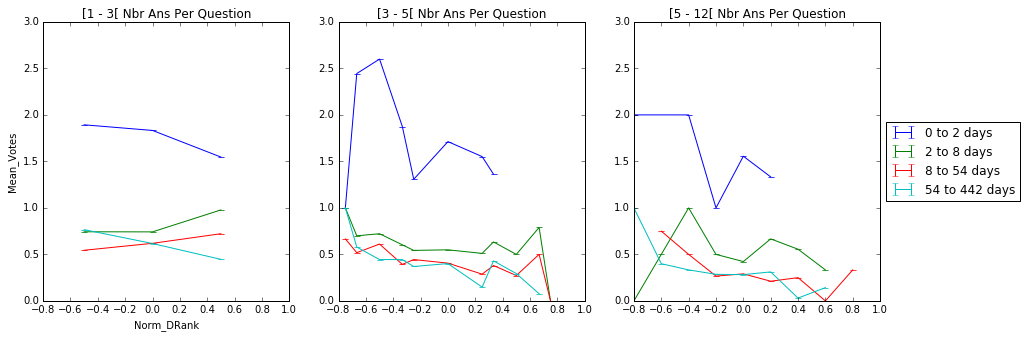

In [81]:
nb_ans = 5
nb_age_groups = 4
data = votes[(votes.Ans_count>1) &(votes.Age_vot_group<=4)]
data = data[(data['Ans_count']<=nb_ans)&(data['Age_vot_group']<=nb_age_groups-1)]
plot_by(data,'Age','Ans_count','Norm_DRank','Votes',15,5,errbars=False)

[]


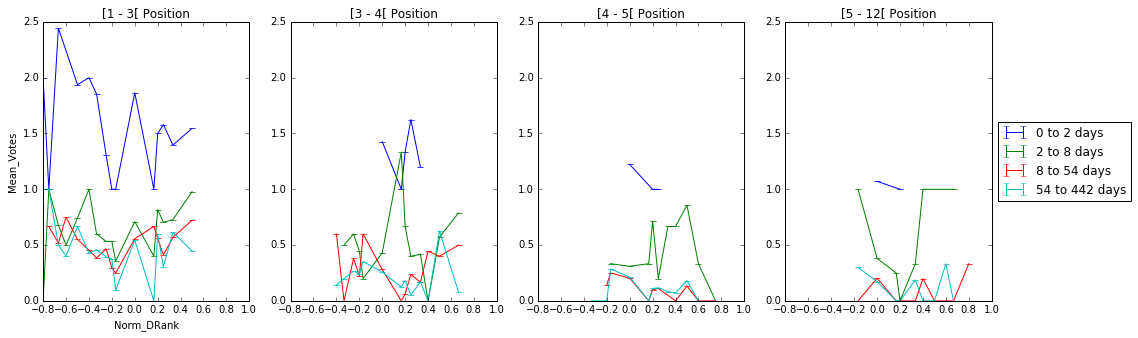

In [82]:
nb_ans = 6
nb_age_groups = 4
data = votes[(votes.Ans_count>1)]#&(votes.Age_vot_group==3)]
data = data[(data['Ans_count']<=nb_ans)&(data['Age_vot_group']<=nb_age_groups-1)]
plot_by(data,'Age','AnsRank','Norm_DRank','Votes',17,5,errbars=False)

[]


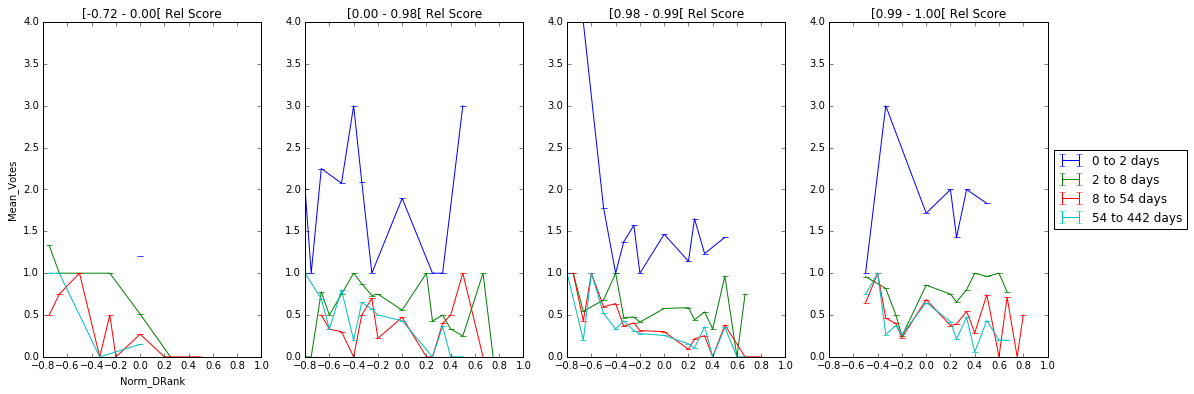

In [83]:
nb_ans = 5
nb_age_groups = 4

data = votes[(votes.Ans_count>1)]
dato = data[(data['Ans_count']<=nb_ans)&(data['Age_vot_group']<=nb_age_groups-1)]

plot_by(dato,'Age','ReScore','Norm_DRank','Votes', 18, 6, errbars=False)

## Regression analysis preparation

In [2]:
import pandas as pd

votes = pd.DataFrame.from_csv('VotesRaw.csv')

In [3]:
votes.head()

,Accepted,AcceptedAnsId,Age,AnsId,AnsRank,Ans_count,DRank,Downvotes,EPbias,Norm_DRank,Norm_Pos,QuestionId,ReScore,Score,Upvotes,Votes,Norm_Pos_2
0,False,-1,0,4,1,3,0,1,0.378686,0,0.333333,1,0,0,2,3,0.111111
2,False,-1,0,5,2,3,0,0,0.263514,0,0.666667,1,0,0,1,1,0.444444
217,False,-1,0,56,3,3,0,0,0.357801,0,1.000000,1,0,0,2,2,1.000000
218,True,56,1,56,1,4,0,0,0.327900,0,0.250000,1,0,2,3,3,0.062500
1,False,56,1,4,2,4,0,0,0.191223,0,0.500000,1,0,1,1,1,0.250000


In [4]:
## Check uniqueness of qidt-position pair for plm and mlogit format from R
votes.groupby(['QuestionId','Age','AnsRank']).apply(lambda df:df.shape[0]>1).reset_index(drop=True).any()

False

In [5]:
#There should not be only 0 choice
sum(votes.groupby(['QuestionId','Age']).apply(lambda df: (df.Votes==0).all()).reset_index(drop=True))

0

In [53]:
from functools import partial

nn_feats =['QuestionId','Age','AnsRank','Votes','ReScore','Norm_Pos','Norm_Pos_2','Norm_DRank','EPbias']
def replicate(df,pos=1):
    #assert df.Ans_count.iloc[0] >= pos,"Target position must be less than or eq than Tot nb of answers."
    binary_ch = pd.DataFrame()
    failures = int(df[df.AnsRank!=pos].Votes.sum())
    #assert df[df.AnsRank==pos].Votes.shape[0]==1,"There must be one ans at a given position per Qid-age pair."
    successes = int(df[df.AnsRank==pos].Votes.iloc[0])
    if failures > 0:
        pos_feats = df[df.AnsRank==pos][nn_feats]
        pos_feats.loc[:,'Votes'] = 0 
        binary_ch = binary_ch.append([pos_feats]*failures,ignore_index=True)
    if successes > 0:
        pos_feats = df[df.AnsRank==pos][nn_feats]
        pos_feats.loc[:,'Votes'] = 1 
        binary_ch = binary_ch.append([pos_feats]*successes,ignore_index=True)
    return binary_ch
for tgt_pos in range(1,6):
    replicated_bin = pd.DataFrame()
    for k,g in votes.groupby(['QuestionId','Age']):
        assert (int(g.Ans_count.iloc[0])==g.Ans_count).all(), 'Ans count must be unique per Qid-age pair'
        if int(g.Ans_count.iloc[0]) >= tgt_pos:
            replicated_bin = replicated_bin.append(replicate(g,pos=tgt_pos))      
    replicated_bin.to_csv('BinCh%d.csv'%(tgt_pos))       
 

In [54]:
replicated_bin[replicated_bin.Votes>1]

,QuestionId,Age,AnsRank,Votes,ReScore,Norm_Pos,Norm_Pos_2,Norm_DRank,EPbias


## Prepare for nnet, replicate rows

In [38]:
qt_idx = votes.groupby(['QuestionId','Age']).count().reset_index(level=[0,1],drop=False)[['QuestionId','Age']]
qt_idx.to_csv('Qt_idx.csv')

In [39]:
# nnet to predict for a fixed nbr of choices
for nb_choices_nnet in range(2,7):
    for_nnet = pd.DataFrame()
    for k,g in votes[votes.Ans_count==nb_choices_nnet].groupby(['Votes']):
        if k>1:
            for_nnet = for_nnet.append([g]*(int(k)),ignore_index=True)
        else:
            for_nnet = for_nnet.append(g,ignore_index=True)
    for_nnet.loc[for_nnet.Votes>1,'Votes']=1
    for_nnet = for_nnet[['QuestionId','AnsRank','Ans_count','AnsId','Age','Votes','ReScore','Norm_Pos','Norm_Pos_2','Norm_DRank','EPbias']]
    for_nnet = for_nnet[for_nnet.Votes>0]
    for_nnet = pd.merge(for_nnet,qt_idx.reset_index(drop=False),how='left',on=['QuestionId','Age'])
    for_nnet.to_csv('Qtnnet%d.csv'%nb_choices_nnet)

In [40]:
for_nnet = pd.DataFrame()
for k,g in votes.groupby(['Votes']):
    if k>1:
        for_nnet = for_nnet.append([g]*(int(k)),ignore_index=True)
    else:
        for_nnet = for_nnet.append(g,ignore_index=True)
    for_nnet.loc[for_nnet.Votes>1,'Votes']=1
    for_nnet = for_nnet[['QuestionId','AnsRank','Ans_count','AnsId','Age','Votes','ReScore','Norm_Pos','Norm_Pos_2','Norm_DRank','EPbias']]
    for_nnet = for_nnet[for_nnet.Votes>0]
    for_nnet = pd.merge(for_nnet,qt_idx.reset_index(drop=False),how='left',on=['QuestionId','Age'])
    for_nnet.to_csv('QtnnetAll.csv')

## Prepare for mlogit, fixed nb of choices

In [41]:
votes_qt_idx = pd.merge(votes,qt_idx.reset_index(drop=False),how='left',on=['QuestionId','Age'])
votes_qt_idx = votes_qt_idx[['AnsId','QuestionId','Ans_count','index','Votes','AnsRank',
                             'Age','ReScore','Norm_Pos','Norm_Pos_2','Norm_DRank','EPbias']]

In [42]:
for nb_choices in range(2,7):
    features = ['AnsId','QuestionId','index','Votes','AnsRank','Age',
        'ReScore','Norm_Pos','Norm_Pos_2','Norm_DRank','EPbias']
    fixed_ch = votes_qt_idx[votes_qt_idx.Ans_count==nb_choices][features]
    fixed_ch.to_csv('Qt%dMlogitFixed.csv'%(nb_choices))

In [43]:
votes_qt_idx.head()

,AnsId,QuestionId,Ans_count,index,Votes,AnsRank,Age,ReScore,Norm_Pos,Norm_Pos_2,Norm_DRank,EPbias
0,4,1,3,0,3,1,0,0.00000,0.333333,0.111111,0.00,0.374883
1,5,1,3,0,1,2,0,0.00000,0.666667,0.444444,0.00,0.254896
2,56,1,3,0,2,3,0,0.00000,1.000000,1.000000,0.00,0.370221
3,56,1,4,1,3,1,1,0.98764,0.250000,0.062500,0.00,0.328707
4,4,1,4,1,1,2,1,0.49073,0.500000,0.250000,-0.25,0.189274


## Prepare for plm package, as a panel 

In [44]:
# test this part later
features = ['ReScore','Norm_Pos','Norm_Pos_2','Norm_DRank','EPbias']
def prepare_logit(df):
    s_df = df.sort_values(by='AnsRank')
    ref = s_df.iloc[-1]
    feats_df = s_df.apply(lambda row: row[features] - ref[features], axis=1).iloc[:-1]
    feats_df['AnsId'] = s_df['AnsId'][:-1]
    feats_df['AnsRank'] = s_df['AnsRank'][:-1]
    feats_df['Votes'] = s_df['Votes'][:-1]
    return feats_df

In [45]:
votes_logit = votes.groupby(['QuestionId','Age']).apply(prepare_logit).reset_index(level=[0,1],drop=False)

In [46]:
get_comp = lambda df: int(df.shape[0])>1 
tt = votes_logit.groupby(['QuestionId','Age','AnsRank']).apply(get_comp).reset_index(drop=True)
sum(tt)

0

In [47]:
votes_logit.shape

(15480, 10)

In [65]:
votes_logit[votes_logit.Votes==0].shape

(7668, 10)

In [48]:
map_qt_idx = votes_logit.groupby(['QuestionId','Age']).count().reset_index(level=[0,1],drop=False)[['QuestionId','Age']]

In [49]:
map_qt_idx.head()

,QuestionId,Age
0,1,0
1,1,1
2,1,2
3,1,5
4,1,8


In [50]:
map_qt_idx.to_csv('Qt_idx_mlogit.csv')

In [69]:
map_qt_idx.duplicated().any()

False

In [70]:
votes_logit.columns

Index([u'QuestionId', u'Age', u'ReScore', u'Norm_Pos', u'Norm_Pos_2',
       u'Norm_DRank', u'EPbias', u'AnsId', u'AnsRank', u'Votes'],
      dtype='object')

In [51]:
## Keep in mind that features are now differences for last choice for a given question-time pair
idxed_X = pd.merge(votes_logit,map_qt_idx.reset_index(drop=False),how='left',on=['QuestionId','Age'])

for_r = idxed_X[['index','QuestionId','AnsId','AnsRank','Votes','Age',
                 'ReScore','Norm_Pos','Norm_Pos_2','Norm_DRank','EPbias']]

In [52]:
for_r.to_csv('QtPanelFull.csv')

In [39]:
for_r.shape

(15480, 10)

In [40]:
for_r[for_r.Votes==0].shape

(7668, 10)

In [76]:
for_r[pd.isnull(for_r).any(axis=1)]

,index,QuestionId,AnsId,AnsRank,Votes,Age,ReScore,Norm_Pos,Norm_Pos_2,Norm_DRank,EPbias


In [77]:
for_r.groupby(['index','AnsRank']).count()

QuestionId  AnsId  Votes  Age  ReScore  Norm_Pos  Norm_Pos_2  \
index AnsRank                                                                 
0     1                 1      1      1    1        1         1           1   
      2                 1      1      1    1        1         1           1   
1     1                 1      1      1    1        1         1           1   
      2                 1      1      1    1        1         1           1   
      3                 1      1      1    1        1         1           1   
2     1                 1      1      1    1        1         1           1   
      2                 1      1      1    1        1         1           1   
      3                 1      1      1    1        1         1           1   
3     1                 1      1      1    1        1         1           1   
      2                 1      1      1    1        1         1           1   
      3                 1      1      1    1        1         1           1   
4     1                 1      1      1    1        1         1           1   
      2                 1      1      1    1        1         1           1   
      3                 1      1      1    1        1         1           1   
5     1                 1      1      1    1        1         1           1   
      2                 1      1      1    1        1         1           1   
      3                 1      1      1    1        1         1           1   
      4                 1      1      1    1        1         1           1   
6     1                 1      1      1    1        1         1           1   
      2                 1      1      1    1        1         1           1   
      3                 1      1      1    1        1         1           1   
      4                 1      1      1    1        1         1           1   
7     1                 1      1      1    1        1         1           1   
      2                 1      1      1    1        1         1           1   
      3                 1      1      1    1        1         1           1   
      4                 1      1      1    1        1         1           1   
      5                 1      1      1    1        1         1           1   
8     1                 1      1      1    1        1         1           1   
      2                 1      1      1    1        1         1           1   
      3                 1      1      1    1        1         1           1   
...                   ...    ...    ...  ...      ...       ...         ...   
7420  1                 1      1      1    1        1         1           1   
7421  1                 1      1      1    1        1         1           1   
7422  1                 1      1      1    1        1         1           1   
      2                 1      1      1    1        1         1           1   
7423  1                 1      1      1    1        1         1           1   
7424  1                 1      1      1    1        1         1           1   
7425  1                 1      1      1    1        1         1           1   
7426  1                 1      1      1    1        1         1           1   
      2                 1      1      1    1        1         1           1   
7427  1                 1      1      1    1        1         1           1   
      2                 1      1      1    1        1         1           1   
7428  1                 1      1      1    1        1         1           1   
7429  1                 1      1      1    1        1         1           1   
7430  1                 1      1      1    1        1         1           1   
7431  1                 1      1      1    1        1         1           1   
7432  1                 1      1      1    1        1         1           1   
7433  1                 1      1      1    1        1         1           1   
7434  1                 1      1      1    1        1         1  